In [1]:
import pandas as pd
import tweepy
import requests
import datetime
import json
import matplotlib.pyplot as plt
from Classes import Data_crawl
from functions import *
import numpy as np

### My Access Keys for Tweepy

In [2]:
# sean19981002
api_key = 'AD9ZnCOeRDtYEiGe45WUtPS2j'
api_key_secret = '8YRO0UU9vAoLCOUn3FO96OXUdEBuJpRIzgyPCTHgyudmt2SZuh'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAF71jAEAAAAAKAm8%2BESJhS4ydqw1pSAd%2FXmL41Q%3DyY2fkJmdECatUXBWKk49JYzBjMFoovBtUn1VrHDiAiwQy3pwR7'

In [3]:
# s10627070
api_key = 'I3N75MY5qJxCvSrLWe0ZG4vQk'
api_key_secret = 'Q3GC8Vr6F2FNqwh7v8rWoDNnA1Qqnn4RjkJ6STVtAQLamw4qCs'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAIPvbAEAAAAApt3kcfjyiVBOLVWMbi1Fu6CLL24%3DuIMwpFYplQqMd68VXXv4eU954tnOQu5vljRnV3xL292k4F5sFR' #old
access_token = '1467171706754453504-EJx2MzY1RtEGHXf3hqBZkANnsc4hA2'
access_token_secret = 'VpVdfP1WhID2nas76BXRTMdXXOTvx1BPO1J9LDYs9QM65'

In [4]:
token = list()
with open('tokens.txt', 'r') as f:
    for line in f:
        line = line.replace('\n', '')
        token.append(line)
token = token[10:]
token

['AAAAAAAAAAAAAAAAAAAAAMgGjQEAAAAAV%2BvTp7Lpi1QJbSCcuFY%2FXvp0SHM%3DemYxzRF5ijRq72Q44Dh7bBd3rR0EriGtVI1XyyI6kAIz8SwlJX',
 'AAAAAAAAAAAAAAAAAAAAALAxjQEAAAAAnmz%2ByL4xpCz84Pl3U8Lg%2BUsyelM%3Dh3wz4pP6TPCFpB9MqgkfusfHbVykCCvVqU3ccZCPVB28bj87VD',
 'AAAAAAAAAAAAAAAAAAAAAJAGjQEAAAAA7SsjLD9VJnhRe3gdvdvdslHq2NQ%3DT3jiyZyyEw3nCyqHWyWlucAUmwRFIKX80B0AkiPAgId9pu1BIr',
 'AAAAAAAAAAAAAAAAAAAAAPwxjQEAAAAAUG%2FmQd1X42iX%2FYsqWpOPk97RyAo%3DmWe7RLkTyX7mxP0K6MhOX6g96fJrdLP2pgffm6cHLEooRKTzao']

## <font color="pink">Biden tweets crawling </font> ##



In [5]:
download = False # 需不需要抓資料，FALSE 的話載入本地資料

today  = '2022-11-07' # date you wanna captured
file_path = 'Biden/' + today + '/'
dataset = Data_crawl(token=token, file_path=file_path)
query = 'from:POTUS -is:retweet' 
tweet_fields = ['author_id', 'created_at', 'retweeted', 'retweet_count', 'favorite_count']


if download:
    tweet_df = dataset.Get_Tweets_Dataframe(
        query=query,
        tweet_fields=tweet_fields
    )
else:
    tweet_df = pd.read_excel(file_path + 'Biden.xlsx')
    tweet_df = tweet_df[73:142] # selecting range you want of Biden's Tweets
    tweet_df[id] = tweet_df['id'].astype('int') # change 'id' from str into int
    tweet_df = tweet_df.reset_index() # reset index
    dataset.Get_Tweets_Dataframe(
        tweet_df=tweet_df, 
        wanna_download=download, 
        query=query, 
        tweet_fields=tweet_fields)

dataset.tweets_df

,index,id,created_at,text,retweeted,retweet_count,favorite_count,140158272155600
0,73,1586798846709227521,Sun Oct 30 19:15:01 +0000 2022,We’re making sure the biggest corporations beg...,False,5400,23297,1586798846709227521
1,74,1586787521920483331,Sun Oct 30 18:30:00 +0000 2022,We’re capping seniors’ out-of-pocket costs for...,False,7253,30591,1586787521920483331
2,75,1586773677869342724,Sun Oct 30 17:35:00 +0000 2022,Jill and I are devastated to learn that at lea...,False,4988,40074,1586773677869342724
3,76,1586719571574235144,Sun Oct 30 14:00:00 +0000 2022,We’re reducing the burden on working- and midd...,False,4120,17949,1586719571574235144
4,77,1586511955572973568,Sun Oct 30 00:15:00 +0000 2022,Oil companies made billions in profits this qu...,False,9393,35207,1586511955572973568
...,...,...,...,...,...,...,...,...
64,137,1584635840818515974,Mon Oct 24 20:00:00 +0000 2022,"Exactly one week ago, we launched our applicat...",False,5782,22305,1584635840818515974
65,138,1584620744624979969,Mon Oct 24 19:00:01 +0000 2022,We know what Republicans in Congress will do i...,False,9317,26758,1584620744624979969
66,139,1584613701176463382,Mon Oct 24 18:32:01 +0000 2022,Republican officials want to put America in de...,False,4678,13701,1584613701176463382
67,140,1584602542239105025,Mon Oct 24 17:47:41 +0000 2022,For two years the COVID virus has been evolvin...,False,2727,13800,1584602542239105025


## <font color="pink">依照 tweet ID 尋找每篇推文的 retweeters</font> 

> * 使用 JSON/XLSX 格式儲存 retweeters
> * 針對每篇 tweet 建立兩個 list，分別把抓到的 ID、UserName 存進 Retweeter_List
> * 將抓取的時間範圍寫在最前面
>
> * <font color=#FF6600> 要用 paginator 抓 retweeters，否則會抓不超過 100 個
> * 練習檔案讀寫務必記得拿 White House，否則複寫以後檔案會消失 (2022/10/06 )  </font>


In [6]:
retweeter_dict = dict() # keys:tweet id, value:list of retweeters
retweeters = set()

if download:
    retweeter_dict = dataset.Get_Retweeters_Multi()
else:
    for i in range(7):
        file = file_path + "retweeters/%d_retweeters.json" % i
        # loading files and combine
        if path.exists(file):
            with open(file, "r") as f:
                json_data = json.load(f)
                for j in json_data.keys():
                    retweeter_dict[j] = json_data[j]

## <font color="pink"> 分布圖 & Target User </font> 

- 依照每篇 tweet 看一下 retweet count ，畫成 bar chart.

- 依照每個 user 轉推的篇數畫出 bar chart，<font color=#FFD382> X軸為 轉推1,2,3... 的篇數，Y軸為人數 </font>
- 分布圖出來以後，設一個底線，把轉推篇數低於這個底線的 user 踢掉，留下的就是 target user

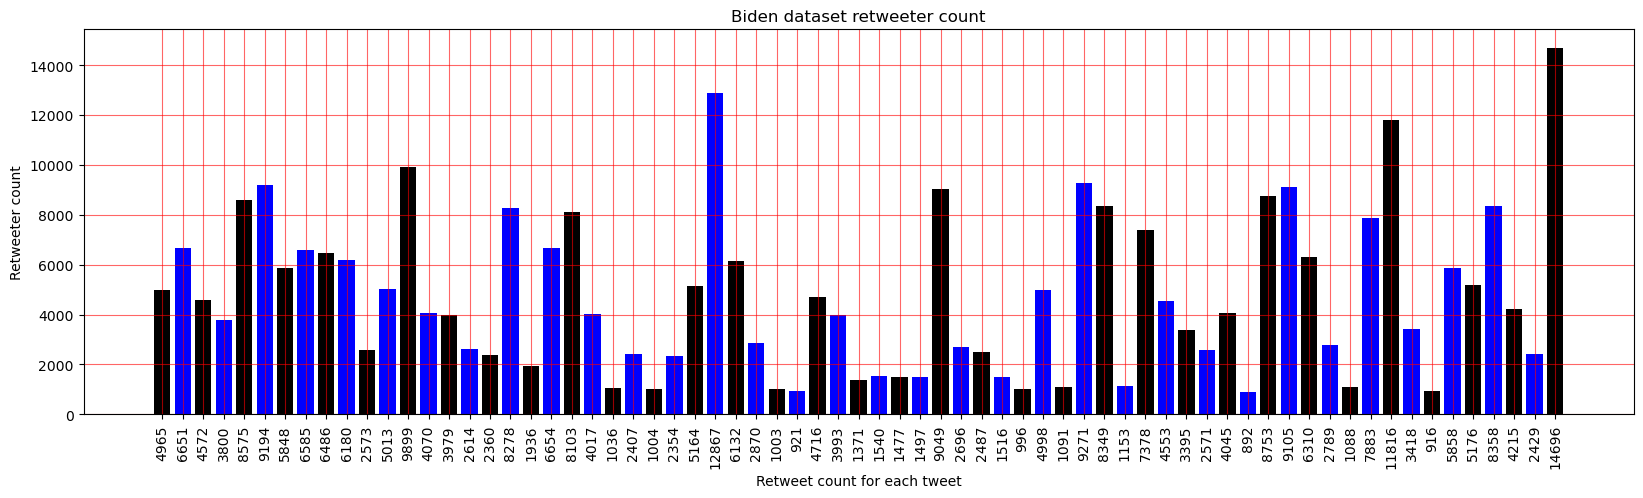

In [7]:
# retweet count for each tweet -- bar chart
count = list()
for id in retweeter_dict.keys():
    count.append(len(retweeter_dict[id]))
retweet_count = list(map(str, count))

plt.figure(figsize = (20,5))
plt.title('Biden dataset retweeter count')
plt.bar(retweet_count, count, color=['black', 'blue'], width=0.8, align='center')
plt.grid(True,color='r',alpha=0.6)
plt.xlabel('Retweet count for each tweet')
plt.ylabel('Retweeter count')
plt.xticks(rotation='vertical')
plt.show()

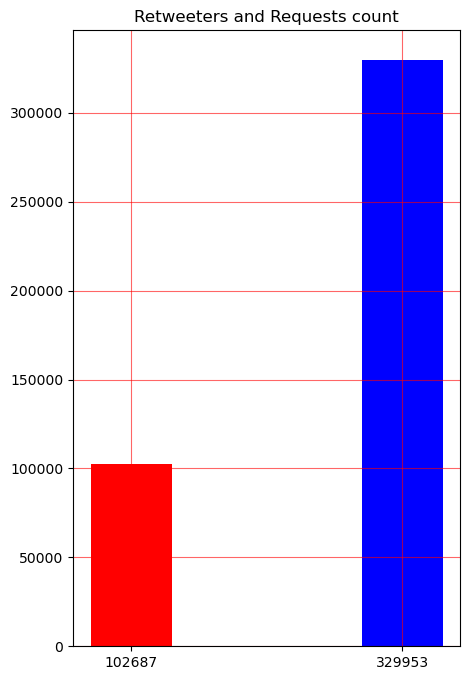

In [8]:
# Union the retweeter lists, filtering the repeated id

retweeters = set()
requests_count = 0
for i in retweeter_dict.keys():
    retweeter_list = set(retweeter_dict[i])
    requests_count += len(retweeter_list)
    retweeters |= retweeter_list # Union into retweeters

# And also, see the ratio of retweeters and requests count --> bar chart
plt.figure(figsize = (5,8))
plt.title('Retweeters and Requests count')
plt.bar([str(len(retweeters)), str(requests_count)], [len(retweeters), requests_count],color=['red', 'blue'], width=0.3, align='center')
plt.grid(True,color='r',alpha=0.6)
plt.show()

## Target User
- 踢掉 retweet 篇數過少的 users，剩下的對象就是 target users.
- 接著再用 target users 去蒐集相對應的 followers.
- Negative Sampling 可能要上.

In [9]:
# start finding retweets count of each user
user_retweet_count = dict()

if path.exists(file_path + "UserRetweetCount.json"):
    with open(file_path + "UserRetweetCount.json", "r") as f:
        user_retweet_count = json.load(f)

else:
    user_retweet_count = UserRetweetCount_MultiCore(
        retweeter_dict=retweeter_dict, 
        retweeters=list(retweeters), 
        parallelism=8, 
        requests_count=requests_count
    )
    with open(file_path + "UserRetweetCount.json", "w") as f:
        json.dump(user_retweet_count, f, indent=True)


In [10]:
# start statistics retweet count

"""
    Retweet count from 1 to len(how many tweets)
    show_list : first element represent 'how many users retweet 1 tweet', so are the rests.

"""
label = [str(i) for i in range(1,70,1)]
show_list = [0 for i in range(tweet_df.shape[0])]

for user in user_retweet_count.keys():
    index = user_retweet_count[user]
    show_list[index-1] += 1

Total users: 102687


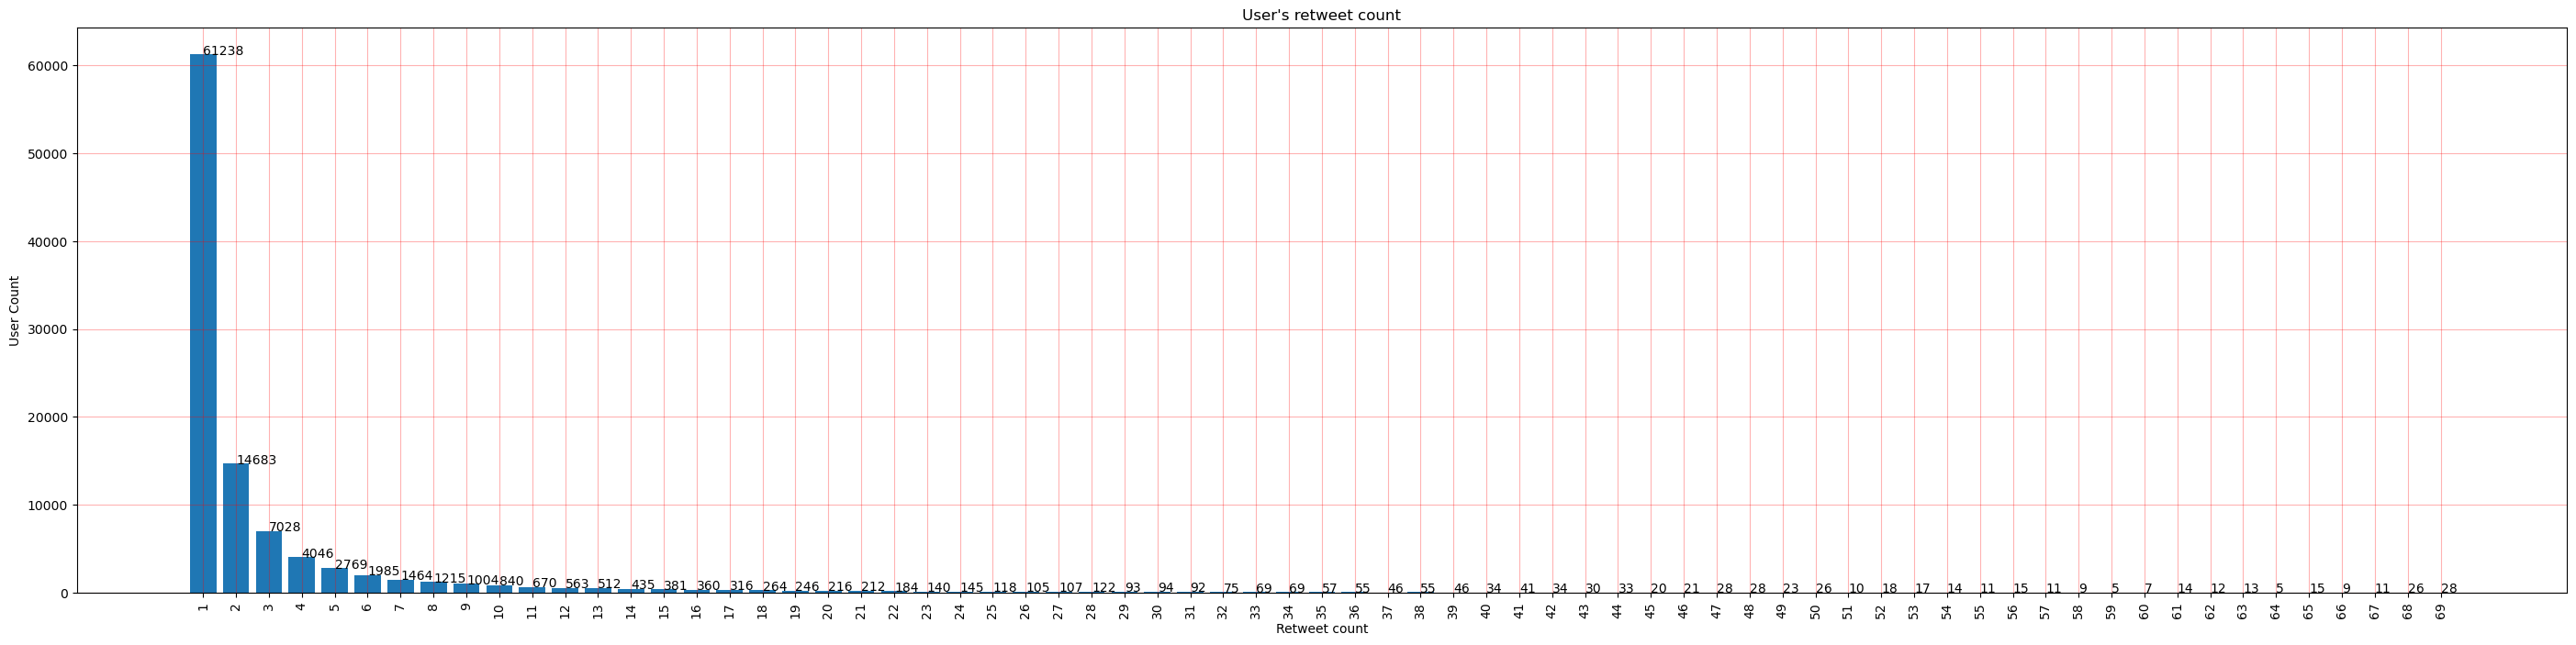

In [11]:
# Draw a bar plot to see
print("Total users: %d" % len(retweeters))
color = (0.3, 0.9, 0.4, 0.6)
plt.figure(figsize = (35,8))
plt.title("User's retweet count")
plt.bar(label, show_list)
plt.grid(True,color='r',alpha=0.3)
plt.xlabel('Retweet count')
plt.ylabel('User Count')
plt.xticks(rotation='vertical')
for index, value in enumerate(show_list):
    plt.text(index, value, str(value))
plt.show()

Total users : 102687
Deleting users of retweet counts lower than 5 : 89764
Total of target users : 12923


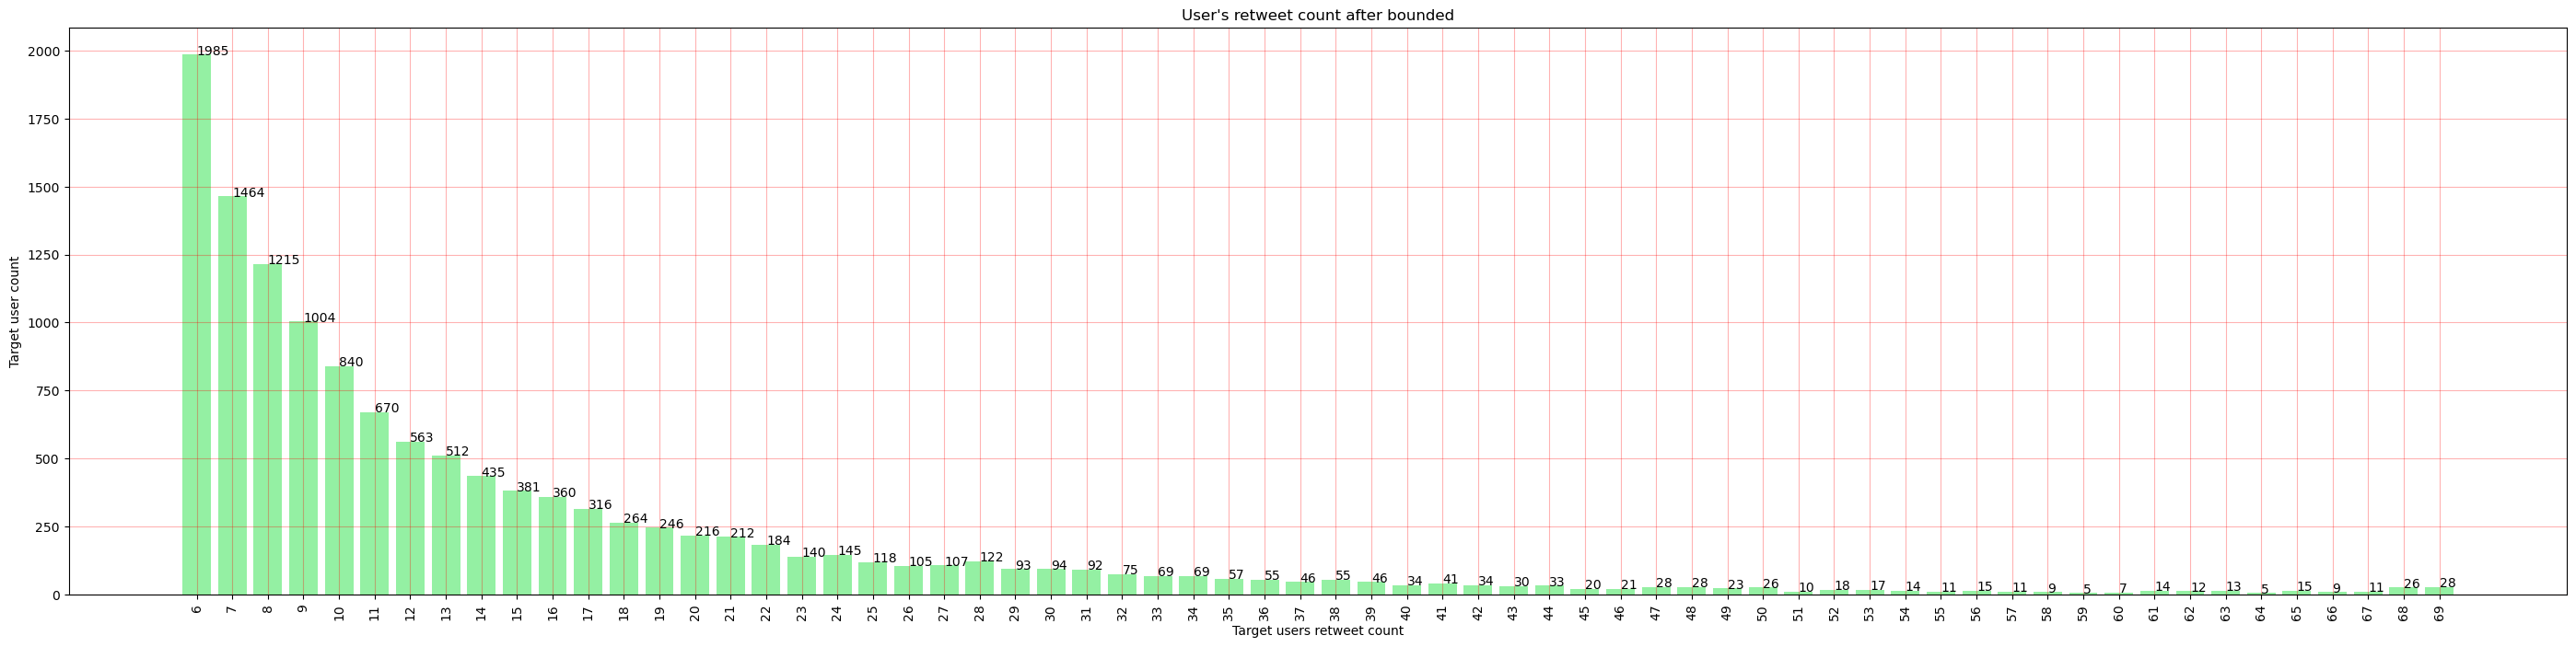

In [12]:
#   Draw a bar plot to see after bounded
"""
    Set bound after observing the user's retweet counts distributionns.
    Most of the users distributed in the range of 1 to 3.
"""


bound = 5
print("Total users :", len(retweeters))
print("Deleting users of retweet counts lower than %d : %d" % (bound, sum(show_list[0:bound])))
print("Total of target users : %d" % sum(show_list[bound:]))

color = (0.3, 0.9, 0.4, 0.6)
plt.figure(figsize = (35,8))
plt.title("User's retweet count after bounded")
plt.bar(label[bound:], show_list[bound:], color=color, width=0.8, align='center')
plt.grid(True,color='r',alpha=0.3)
plt.xlabel('Target users retweet count')
plt.ylabel('Target user count')
plt.xticks(rotation='vertical')
for index, value in enumerate(show_list[bound:]):
    plt.text(index, value, str(value))
plt.show()

In [13]:
wanna_find_target = False
target_users = list()

if path.exists(file_path + "target_users.json"):   # need to run the function to find target users
    with open(file_path + "target_users.json", "r") as f:
        json_file = json.load(f)
        target_users = list(json_file)

    
else: # load the file of target users
    target_users = FindTargetUser_MultiCore(
        bound = bound,
        retweeters = user_retweet_count,
    )
    target_users = sorted(target_users)
    print("Target users :", len(target_users))
    with open(file_path + "target_users.json", "w") as f:
        json.dump(target_users, f, indent=True)

### 將過濾非 target users 以後的貼文的轉推數以及他與 target users 的比例轉為 dataframe並畫圖表

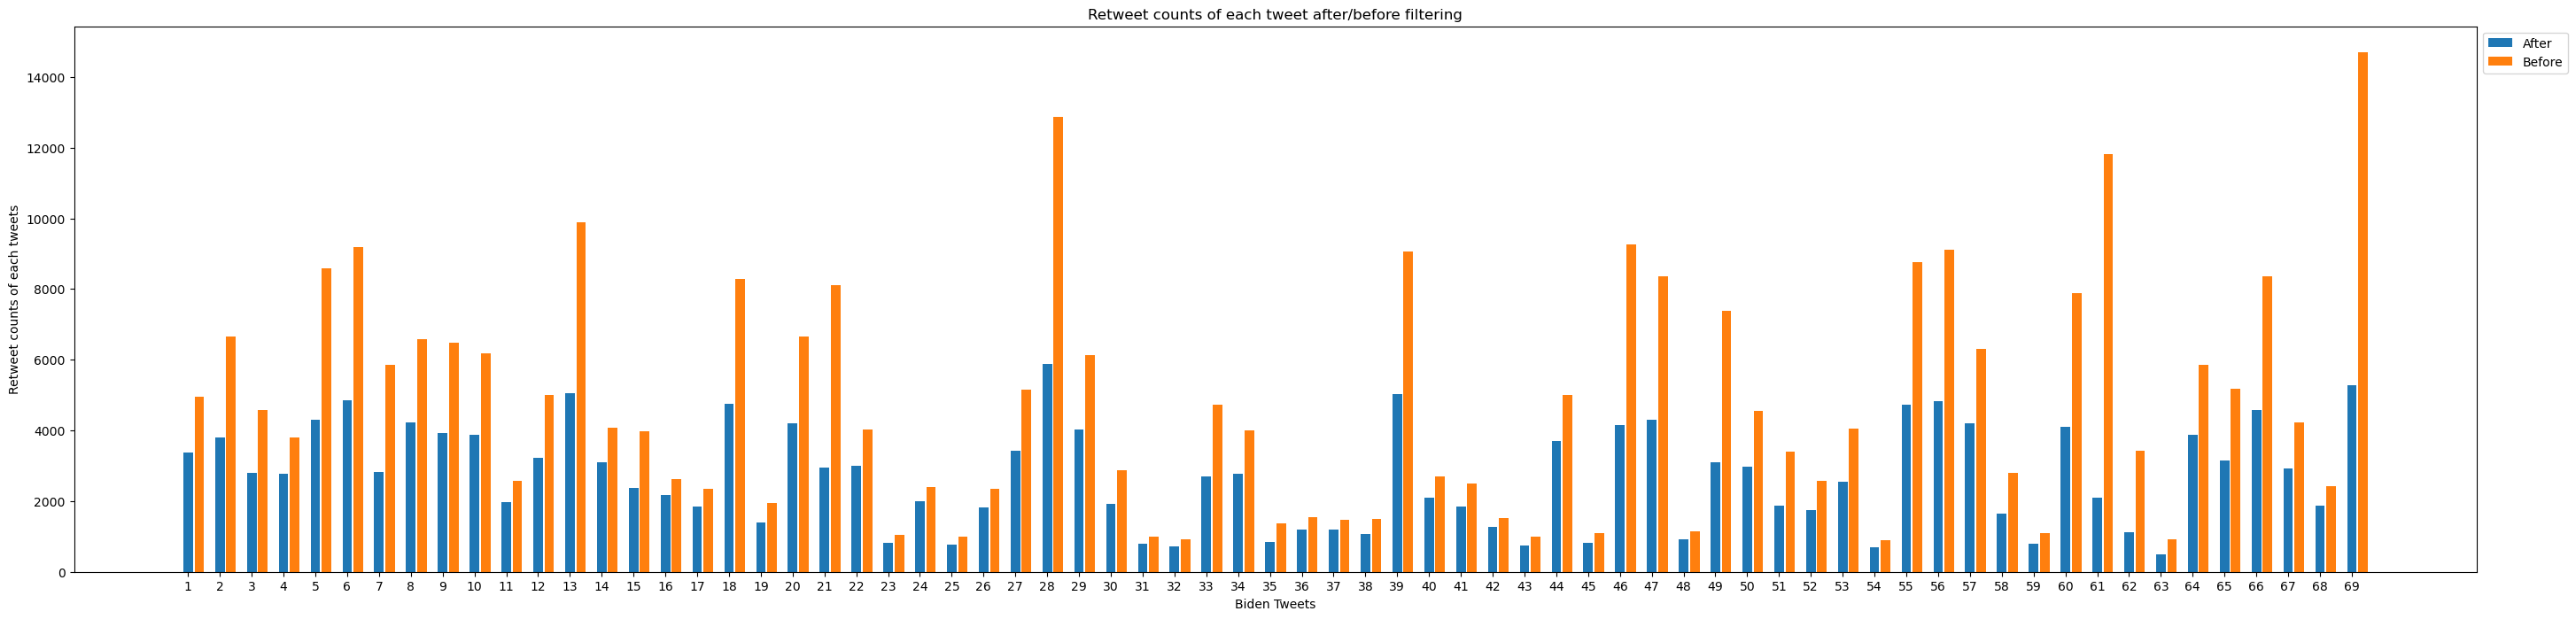

In [14]:
# retweet count for each tweet after filtering
count = [[], []]
tmp = dict()
for id in retweeter_dict.keys():
    tmp[id] = set(target_users) & set(retweeter_dict[id])
    count[0].append(len(tmp[id]))
    count[1].append(len(retweeter_dict[id]))
X = [str(i) for i in range(1, len(count[0])+1, 1)]
X_axis = np.arange(len(X))

plt.figure(figsize = (35,8))
plt.bar(X_axis, count[0], width=0.3,  label='After')
plt.bar(X_axis+0.35, count[1], width=0.3,  label='Before')
plt.xticks(X_axis, X)
plt.xlabel("Biden Tweets")
plt.ylabel("Retweet counts of each tweets")
plt.title("Retweet counts of each tweet after/before filtering")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [15]:
ori = [len(retweeter_dict[i]) for i in retweeter_dict.keys()]
aft = [len(tmp[i]) for i in retweeter_dict.keys()]
df_data = {
    "id" : list(retweeter_dict.keys()),
    "Original retweet count" : count[1],
    "After filtering" : count[0]
}
my_df = pd.DataFrame(df_data)
#my_df['id'] = my_df[id].astype('str')
my_df['Ratio of after/total'] = my_df['After filtering'].div(len(retweeters)).round(3)
my_df.to_excel(file_path + "compare%d.xlsx" % bound, index=False, header=True, sheet_name="Threshold=%d" % bound)

## <font color="pink"> 開始針對 Day 11 ~ Day 17 的 Biden tweet 蒐集轉推的時間 </font> 

> - #### 把 dataG.xlsx 裡面的 tweet id 拿出來(biden_tweets)，送進 dataset.Get_User_Tweets_Multi()，原本 type 為 str，須轉換成 int
> - #### crawling target user 的貼文牆，若有轉推這段時間內的貼文，寫進 txt file
>       * txt : target id, referenced id, tweet id, created at

In [16]:
type(target_users[0])

int

In [17]:
file_path

'Biden/2022-11-07/'

In [18]:
biden_tweets = list()
with open(file_path + "user_tweets/dataG.xlsx", "r") as f:
    df = pd.read_excel(file_path + "user_tweets/dataG.xlsx")
    biden_tweets = list(df['id'].astype('int'))

print("Tweets for data graph:")
print("  * Tweets count :", len(biden_tweets))
print("  * Element type :", type(biden_tweets[0]))

Tweets for data graph:
  * Tweets count : 71
  * Element type : <class 'int'>


In [19]:
"""
    get tweets from the post wall of each target user.
    and dont captured those target users who already been crawed.
"""

dataset.Get_User_Tweets_Multi(
    target_user=target_users,
    biden_tweets=biden_tweets
)


Already crawled : 12923
ALL data had already crawled !


In [20]:
# get follower list of every target users

"""
dataset.Get_Followers_Multi(
    target_users = target_users,
    file_path = file_path
)
"""

'\ndataset.Get_Followers_Multi(\n    target_users = target_users,\n    file_path = file_path\n)\n'

## <font color="pink"> Graph Construction </font> ##


1. 把所有 target user 的 id 一起 encoding 成 0, 1, 2, 3, ... 
   
2. 收集每個 target user 的追蹤關係後再下去比對，有出現在清單上面的 user id，就代表他們有 edge
3. 全部用 follow 的關係當 edge 建圖，會有一張 Base Graph
4. 每篇 tweet 以 base graph 為基礎來建 data graph，每一個 data graph 的區別是權重的不同
5. 如果某兩個 user 有共同轉推同一篇 tweet ，那這兩個 user 在這張 data graph 的權重 + 1


In [21]:
retweeters_set = set() # 把 retweeters 用成集合，方便做 union
requests = int(0) # total capture requests
for tweet_id in json_file:
    retweeters = set(json_file[tweet_id])
    requests += len(retweeters)
    retweeters_set = retweeters_set.union(retweeters) # set union

plt.title('Biden dataset  ' + filename)
plt.grid(True,color='r',alpha=0.6)
v_label = 'Retweeter (' + str(len(retweeters_set)) + ')'
r_label = 'Requests (' + str(requests) + ')'
plt.bar([v_label, r_label], [len(retweeters_set), requests], color=['orange', 'blue'], width=0.4)
plt.figure(figsize = (1,2))
plt.show()

IndexError: list index out of range

In [ ]:
# 檢查有沒有重複
print(len(retweeters_set.difference()))
retweeters_set = sorted(retweeters_set)

#### 2. Encoding
- 將所有的 retweeter <font color='#FF1212'> (vertex)</font> 的 user id encoding 成 0,1,2,3...，方便建 adjacency matrix
- json file 的 multiple objects 最前面與最後面要加中括弧[]，objects 之間要加逗號

In [ ]:

wanna_save = True
# json file 再多一個 object -> user id : following list
user_follower = dict.fromkeys(retweeters_set)

for id in user_follower.keys():
    followers = []
    for follwer in tweepy.Paginator(client.get_users_followers, id).flatten():
        followers.append(follwer.id)
    user_follower[id] = followers


In [ ]:
if wanna_save:
    with open('2022-10-06_followers.json', 'w') as f: # 這裡記得改掉 不然又寫錯
        foller_json = json.dumps(user_follower)
        f.write(foller_json)

> 接下來要將 user's 的 followers，跟 retweeters_set 做比較，不在 retweeter_set 裡面的 id 直接踢掉
> 
> 剩下來的存起來，用來建 edge list

In [ ]:
encoding_table = dict()
for i,j in zip(retweeters_set, range(len(retweeters_set))):
    encoding_table[i] = j